In [78]:
# Some useful imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import eval_hermitenorm, factorial
from scipy.stats import norm
from scipy.linalg import expm
from sympy import symbols, expand, sqrt, collect, Poly
from sympy import pprint, simplify

In [94]:
# Déclaration des variables symboliques
v1, v2, x = symbols('v1 v2 x')
m, n, q = symbols('m n q', integer=True)
beta, g1, g2, sigma, sigma_w, rho = symbols('beta g1 g2 sigma sigma_w rho')
vmin, vmax, V0, r, r1, r2, k, theta, delta = symbols('vmin vmax V0 r r1 r2 k theta delta')

def polynome_total_maxima(beta, g1, g2, sigma, sigma_w, rho,
                          vmin, vmax, V0, r, r1, r2, k, theta, delta,
                          m, n, q, v1, v2, x):
    # V est une fonction linéaire de v1 et v2
    V = V0 + g1 * v1 + g2 * v2

    # Q est un polynôme de V
    Q = expand(beta * (V - vmin) * (vmax - V))

    # Terme G1 (drift)
    G1 = (
        (-r1 * v1 + k * (theta - V)) * m * v1**(m-1) * v2**n * x**q
        + (-r2 * v2 + k * (theta - V)) * n * v1**m * v2**(n-1) * x**q
        + (r - delta - V) * v1**m * v2**n * sqrt(q) / sigma_w * x**(q-1)
    )

    # Terme G2 (diffusion) EXACTEMENT comme Maxima (avec doublons)
    G2 = (
        sigma**2 * Q * m * (m - 1) * v1**(m-2) * v2**n * x**q
        + sigma**2 * Q * m * n * v1**(m-1) * v2**(n-1) * x**q
        + rho * sigma * Q * m * sqrt(q) / sigma_w * v1**(m-1) * v2**n * x**(q-1)
        + sigma**2 * Q * m * n * v1**(m-1) * v2**(n-1) * x**q
        + sigma**2 * Q * n * (n - 1) * v1**m * v2**(n-2) * x**q
        + rho * sigma * Q * n * sqrt(q) / sigma_w * v1**m * v2**(n-1) * x**(q-1)
        + rho * sigma * Q * m * sqrt(q) / sigma_w * v1**(m-1) * v2**n * x**(q-1)
        + rho * sigma * Q * n * sqrt(q) / sigma_w * v1**m * v2**(n-1) * x**(q-1)
        + V * sqrt(q * (q - 1)) / sigma_w**2 * v1**m * v2**n * x**(q-2)
    )

    # Polynôme final
    G = expand(G1 + (1/2) * G2)

    return G
    
# Définir les variables symboliques
v1, v2, x = symbols('v1 v2 x')

# Appeler la fonction en passant toutes les variables y compris v1, v2, x
G = polynome_total(beta, g1, g2, sigma, sigma_w, rho,
                   vmin, vmax, V0, r, r1, r2, k, theta, delta,
                   m, n, q, v1, v2, x)

# Regroupement des termes par puissances de v1, v2, x
G_collected = collect(G, [v1, v2, x], evaluate=True)

print(G_collected)

-0.5*V0**2*beta*m**2*sigma**2*v1**(m - 2)*v2**n*x**q - 1.0*V0**2*beta*m*n*sigma**2*v1**(m - 1)*v2**(n - 1)*x**q - 1.0*V0**2*beta*m*sqrt(q)*rho*sigma*v1**(m - 1)*v2**n*x**(q - 1)/sigma_w + 0.5*V0**2*beta*m*sigma**2*v1**(m - 2)*v2**n*x**q - 0.5*V0**2*beta*n**2*sigma**2*v1**m*v2**(n - 2)*x**q - 1.0*V0**2*beta*n*sqrt(q)*rho*sigma*v1**m*v2**(n - 1)*x**(q - 1)/sigma_w + 0.5*V0**2*beta*n*sigma**2*v1**m*v2**(n - 2)*x**q + 0.5*V0*beta*m**2*sigma**2*v1**(m - 2)*v2**n*vmax*x**q + 0.5*V0*beta*m**2*sigma**2*v1**(m - 2)*v2**n*vmin*x**q + 1.0*V0*beta*m*n*sigma**2*v1**(m - 1)*v2**(n - 1)*vmax*x**q + 1.0*V0*beta*m*n*sigma**2*v1**(m - 1)*v2**(n - 1)*vmin*x**q + 1.0*V0*beta*m*sqrt(q)*rho*sigma*v1**(m - 1)*v2**n*vmax*x**(q - 1)/sigma_w + 1.0*V0*beta*m*sqrt(q)*rho*sigma*v1**(m - 1)*v2**n*vmin*x**(q - 1)/sigma_w - 0.5*V0*beta*m*sigma**2*v1**(m - 2)*v2**n*vmax*x**q - 0.5*V0*beta*m*sigma**2*v1**(m - 2)*v2**n*vmin*x**q + 0.5*V0*beta*n**2*sigma**2*v1**m*v2**(n - 2)*vmax*x**q + 0.5*V0*beta*n**2*sigma**2*v1**m*v2

In [45]:
class JacobiPricing:
    def __init__(self, V0, V01, V02, X0, v_min, v_max, sigma, rho, kappa, theta, delta, mu_w, sigma_w, Rho, Gamma, r):
        self.V0 = V0
        self.V01 = V01
        self.V02 = V02
        self.X0 = X0
        self.v_min = v_min
        self.v_max = v_max
        self.sigma = sigma
        self.rho = rho
        self.kappa = kappa
        self.theta = theta
        self.delta = delta
        self.mu_w = mu_w
        self.sigma_w = sigma_w
        self.Rho = Rho
        self.Gamma = Gamma
        self.r = r
        self.beta = 1 / (np.sqrt(self.v_max) - np.sqrt(self.v_min))**2

    def Q(self, v1, v2):
        V = self.V0 + self.Gamma[0] * v1 + self.Gamma[1] * v2
        return self.beta * (V - self.v_min) * (self.v_max - V)

    def monte_carlo(self, V0, X0, paths, f):
        values = f(paths[:, -1, 1]) 
        mean = np.mean(values)
        std = np.std(values, ddof=1)
        return mean, std


    def I_call(self, N, mu, nu):
        res = np.zeros(N+1)
        res[0] = np.exp(nu**2/2) * norm.cdf(nu-mu)
        for i in range(1, N+1):
            res[i] = eval_hermitenorm(i-1, mu) * np.exp(mu*nu) * norm.pdf(mu) + nu * res[i-1]
        return res

    def f_call(self, N, k, T):
        mu = (k-self.mu_w) / self.sigma_w
        nu = self.sigma_w
        I = self.I_call(N, mu, nu)
        f = np.zeros(N+1)
        f[0] = np.exp(-self.r*T+self.mu_w) * I[0] - np.exp(-self.r*T+k) * norm.cdf(-mu)
        for i in range(1, N+1):
            f[i] = np.exp(-self.r*T+self.mu_w) * (1/np.sqrt(factorial(i, exact=False))) * self.sigma_w * I[i-1]
        return f

    def G_polynomial(self, m, n, q, v1, v2, x):
        # Déclaration symbolique
        sigma = self.sigma
        rho = self.rho
        k = self.kappa
        theta = self.theta
        delta = self.delta
        r = self.r
        sigma_w = self.sigma_w
        beta = self.beta
        v_min = self.v_min
        v_max = self.v_max
        V0 = self.V0
        Gamma = self.Gamma
        r1 = self.Rho[0]
        r2 = self.Rho[1]
        g1 = self.Gamma[0]
        g2 = self.Gamma[1]
        
        # Variables symboliques
        V = V0 + Gamma[0] * v1 + Gamma[1] * v2
        Q = beta * (V - v_min) * (v_max - V)

        # Terme G1
        G1 = (
            (-r1 * v1 + k * (theta - V)) * m * v1**(m - 1) * v2**n * x**q
            + (-r2 * v2 + k * (theta - V)) * n * v1**m * v2**(n - 1) * x**q
            + (r - delta - V) * v1**m * v2**n * sqrt(q) / sigma_w * x**(q - 1)
        )

        # Terme G2
        G2 = (
            sigma**2 * Q * m * (m - 1) * v1**(m - 2) * v2**n * x**q
            + sigma**2 * Q * m * n * v1**(m - 1) * v2**(n - 1) * x**q
            + rho * sigma * Q * m * sqrt(q) / sigma_w * v1**(m - 1) * v2**n * x**(q - 1)
            + sigma**2 * Q * m * n * v1**(m - 1) * v2**(n - 1) * x**q
            + sigma**2 * Q * n * (n - 1) * v1**m * v2**(n - 2) * x**q
            + rho * sigma * Q * n * sqrt(q) / sigma_w * v1**m * v2**(n - 1) * x**(q - 1)
            + rho * sigma * Q * m * sqrt(q) / sigma_w * v1**(m - 1) * v2**n * x**(q - 1)
            + rho * sigma * Q * n * sqrt(q) / sigma_w * v1**m * v2**(n - 1) * x**(q - 1)
            + V * sqrt(q * (q - 1)) / sigma_w**2 * v1**m * v2**n * x**(q - 2)
        )

        G = expand(G1 + (1 / 2) * G2)

        return G

    def pi(self, N):
        p = 0
        h = {}
        h_inv = []
        for d in range(0, N + 1):
            for i in range(0, d + 1):
                for j in range(0, d - i + 1):
                    h[(i, j, d - i - j)] = p
                    h_inv.append((i, j, d - i - j))
                    p += 1
        return h, np.array(h_inv)

    def H(self, m, n, q, v1, v2, x):
        return (v1**m) * (v2**n) * (1/np.sqrt(factorial(q, exact=False))) * eval_hermitenorm(q, (x-self.mu_w)/self.sigma_w)

    def l(self, N, T):
        from sympy import symbols
        v1, v2, x = symbols('v1 v2 x')
        r1, r2 = symbols('r1 r2')  # Assure-toi que tu passes ou définis r1, r2 quelque part
        
        M = (N + 1) * (N + 2) * (N + 3) // 6
        h, h_inv = self.pi(N)

        H_lst = np.zeros(M)
        for i in range(M):
            (m, n, q) = h_inv[i]
            H_lst[i] = self.H(m, n, q, self.V01, self.V02, self.X0)
        
        G_matrix = np.zeros((M, M), dtype=object)  # Stockage symbolique
        
        for d in range(0, N + 1):
            for i in range(0, d + 1):
                for j in range(0, d - i + 1):
                    m, n, q = i, j, d - i - j
                    G = self.G_polynomial(m, n, q, v1, v2, x)
                    for a in range(m-2, m+3):
                        for b in range(n-2, n+3):
                            for c in range(q-2, q+1):
                                if(a>=0 and a<=N and a>=0 and b<=N and b>=0 and b<=N and c>=0 and c<=N and a+b+c<=N):
                                    coeff = G.coeff(v1, a).coeff(v2, b).coeff(x, c)
                                    G_matrix[h[(a,b,c)], h[(m,n,q)]]
        E = np.zeros((M, N+1))
        for i in range(N+1):
            E[h[(0, 0, i)], i] = 1
        G_exp = expm(T * G_matrix) 

        l = H_lst @ G_exp @ E

        return l

    def price_call(self, N, k, T):
        f = self.f_call(N, k, T)
        l = self.l(N, T)
        return np.dot(f, l)

In [56]:
# Paramètres du modèle
V0 = 0.04
V01 = 0.
V02 = 0.
X0 = 0
v_min = 10**(-4)
v_max = 0.08
sigma = 1.
rho = -0.5
kappa = 0.5
theta = 0.04
delta = 0.
sigma_w = sigma
mu_w = 0.1
Rho = np.array([0.1, 0.2]) 
Gamma = np.array([0.3, 0.4])
r = 0.    

# Paramètres du Call
k = 0.02
T = 1/12
N = 1

# Modèle de Jacobi
model = JacobiPricing(V0, V01, V02, X0, v_min, v_max, sigma, rho, kappa, theta, delta, mu_w, sigma_w, Rho, Gamma, r)

price = model.price_call(N, k, T)
print(price)

0.8675772819097742


0.8675772819097742
-0.012173101982315554
0.15582847544261103
0.08416286761630058
0.07128485076774758
0.05914974559065285


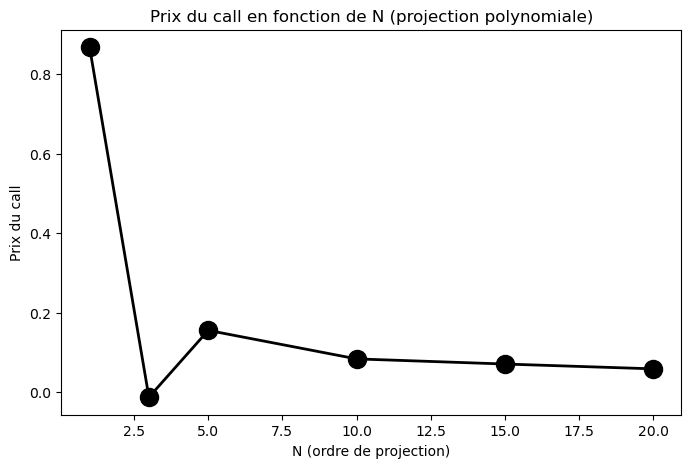

In [60]:
# Calcul du prix pour différents ordres N
N_vals = [1, 3, 5, 10, 15, 20]
prices = []

for N in N_vals:
    price = model.price_call(N, k, T)
    print(price)
    prices.append(price)

# Tracer la courbe
plt.figure(figsize=(8, 5))
plt.plot(N_vals, prices, marker='o', markersize=13, color='black', linewidth=2)
plt.title("Prix du call en fonction de N (projection polynomiale)")
plt.xlabel("N (ordre de projection)")
plt.ylabel("Prix du call")
plt.show()